In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

import nc_time_axis
import cftime
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from cmocean import cm as cmo

import gsw
from GG_mthesis import utils as utils

%matplotlib inline

In [2]:
import os
os.chdir('C:\\Users\\gian_\\repos\\mthesis_gianlucca')
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

In [3]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')

In [4]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_transect.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

In [5]:
#Let's calculate the distances
distance = []
for coord in range(len(ds.lat)-1):
    distance.append(utils.geo.getPathLength(ds.lat[coord],ds.lon[coord],ds.lat[coord+1],ds.lon[coord+1]))
distance = np.array(distance)

#And the cumulative distance
distance_cum = np.insert(np.cumsum(distance), 0, 0)

ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})

[Text(0, 0.5, 'Distance travelled'), Text(0.5, 0, 'Time')]

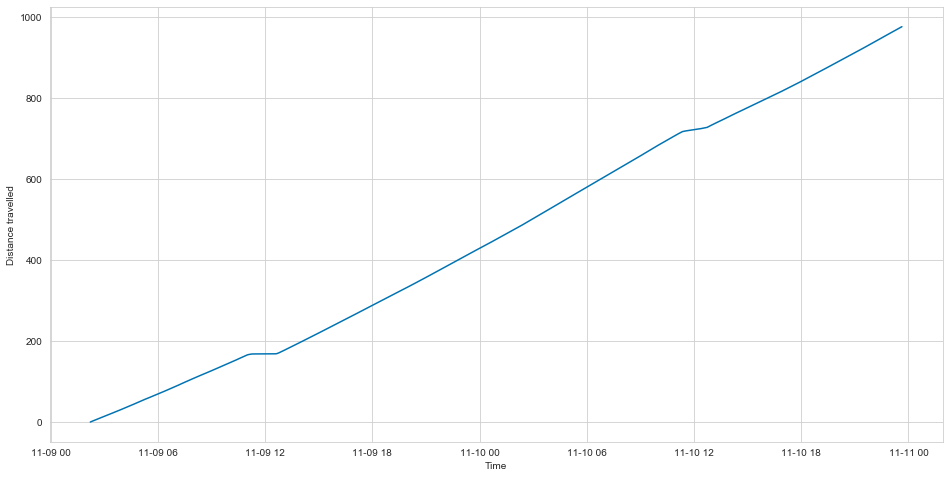

In [6]:
fig, ax0 = plt.subplots(figsize=(16,8))
sns.lineplot(y=ds.distance_cum/1000, x=ds.time)

ax0.set(xlabel='Time', ylabel='Distance travelled')

In [7]:
time_diff = []
for time in range(len(ds.time)-1):
    time_diff.append(np.array((ds.time[time+1]) - np.array(ds.time[time]))/np.timedelta64(1, 's'))
time_diff = xr.DataArray(time_diff,dims={'distance':distance},coords={'distance':distance})

In [8]:
vel = time_diff.distance/time_diff*3.6

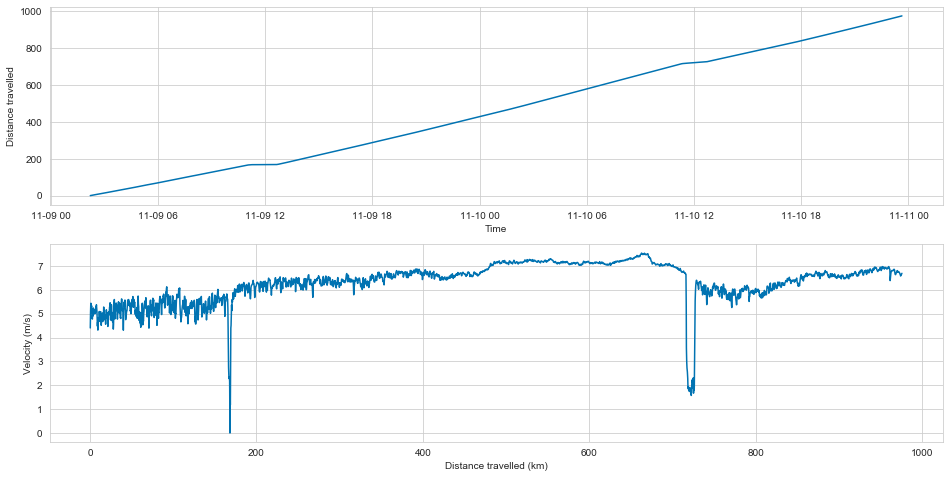

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(16,8))
sns.lineplot(y=ds.distance_cum/1000, x=ds.time, ax=ax0)

sns.lineplot(x=distance_cum[1:]/1000,y=vel/3.6, ax=ax1)

ax0.set(xlabel='Time', ylabel='Distance travelled')
ax1.set(xlabel='Distance travelled (km)', ylabel='Velocity (m/s)')

plt.savefig('C:\\Users\\gian_\\repos\\mthesis_gianlucca\\results\\preprocessing\\vessel_speed.png', bbox_inches='tight', format='png')

In [69]:
distance = gsw.distance(np.array(ds.lon), np.array(ds.lat))
distance_cum = np.insert(np.cumsum(distance), 0, 0)
ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})
ds = ds.set_coords('distance_cum')
ds['distance_cum'].attrs = {
    'long_name': 'Cumulative distance',
    'standard_name': 'distance_cum',
    'units': 'm',
    'description': 'cumulative distance between sampling points calculated using gsw'
}

In [21]:
ds

<xarray.Dataset>
Dimensions:           (time: 2726)
Coordinates:
    lat               (time) float64 -52.5 -52.5 -52.51 ... -61.19 -61.19 -61.2
    lon               (time) float64 -58.17 -58.17 -58.17 ... -57.09 -57.09
    depth             (time) float32 6.5 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5 6.5
  * time              (time) datetime64[ns] 2017-11-09T02:12:59.999680 ... 2017-11-10T23:37:59.997824
    distance_cum      (time) float64 0.0 264.2 567.0 ... 9.755e+05 9.759e+05
Data variables:
    attenuation       (time) float32 0.3768252 0.35738423 ... 0.37621197
    conductivity_tsg  (time) float32 3.44636 3.446025 ... 2.85068 2.85017
    chl-a             (time) float32 3.82668 3.51624 3.44292 ... 1.41336 1.4157
    sal_tsg_cal       (time) float32 33.695 33.69425 33.69085 ... 33.934 33.9305
    sal_tsg_nocal     (time) float32 33.6981 33.69735 ... 33.9371 33.9336
    temp_hull_1       (time) float32 6.70895 6.69845 ... -0.55975 -0.5741
    temp_hull_2       (time) float32 6.72655 6.7223 6.72065 ... -0.5524 -0.5659
    temp_cond_tsg     (time) float32 7.4051 7.40175 7.41585 ... 0.3236 0.3199
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

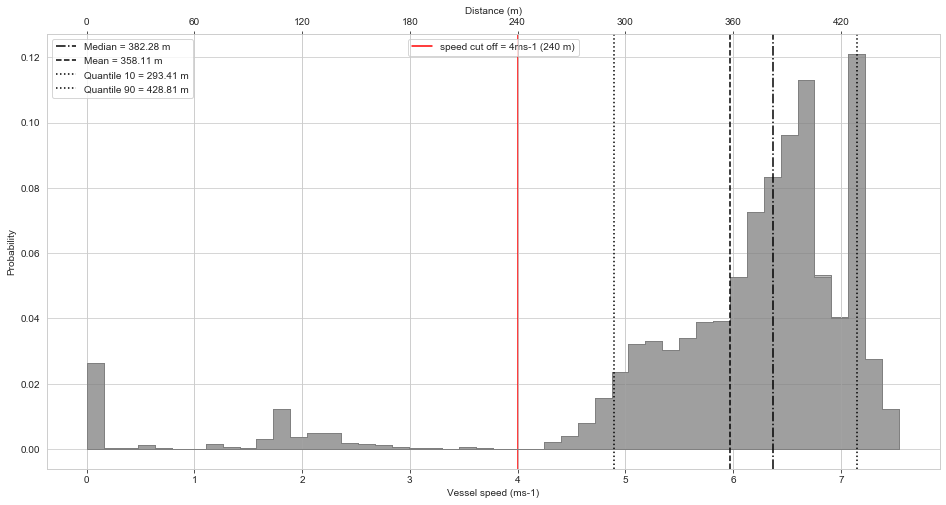

In [61]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(16,8))
ax1 = ax0.twiny()

sns.histplot(vel/3.6, element='step', stat='probability', color='grey', alpha = 0.5, ax=ax0)
sns.histplot(distance, element='step', stat='probability', color='grey', alpha =0.5, ax=ax1)

ax1.axvline(x=np.median(distance), label=str(('Median = ') + str(round(np.median(distance),2)) 
    + str(' m')), color='black', linestyle='-.')
ax1.axvline(x=np.mean(distance), label=str(('Mean = ') + str(round(np.mean(distance),2)) 
    + str(' m')), color='black', linestyle='--')
ax1.axvline(x=np.quantile(distance, .10), label=str(('Quantile 10 = ') + str(round(np.quantile(distance, .10),2)) 
    + str(' m')), color='black', linestyle=':',)
ax1.axvline(x=np.quantile(distance, .90), label=str(('Quantile 90 = ') + str(round(np.quantile(distance, .90),2)) 
    + str(' m')), color='black', linestyle=':')
ax1.legend(loc='upper left')

ax0.axvline(x=4, label='speed cut off = 4ms-1 (240 m)', color='red', linestyle='-')

ax1.set_xticks(np.arange(0, 460, 60))

ax0.set(xlabel='Vessel speed (ms-1)')
ax1.set(xlabel='Distance (m)')

ax0.legend(loc='upper center')

plt.savefig('C:\\Users\\gian_\\repos\\mthesis_gianlucca\\results\\preprocessing\\vessel_speed_hist.png', bbox_inches='tight', format='png')

In [74]:
distance_aux = np.insert(distance, 0, 999)
ds['distance_aux'] = xr.DataArray(distance_aux,dims={'time':ds.time},coords={'time':ds.time})
ds['distance_aux'].attrs = {
    'long_name': 'Auxiliary distances',
    'standard_name': 'distance_aux',
    'units': 'm',
    'description': 'Auxiliary variable composed of the distances between datapoint with an additional point inserted as the first value, being the median. This is in order to be able to sample out of the dataset acroding to the distance. That way, e.g., if one wanted to sample all values with a distance greater than 200m, the reaching point of each distance sample would be excluded.'
}

In [75]:
ds.where(ds.distance_aux >= 240)

<xarray.Dataset>
Dimensions:           (time: 2726)
Coordinates:
    lat               (time) float64 -52.5 -52.5 -52.51 ... -61.19 -61.19 -61.2
    lon               (time) float64 -58.17 -58.17 -58.17 ... -57.09 -57.09
    depth             (time) float32 6.5 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5 6.5
  * time              (time) datetime64[ns] 2017-11-09T02:12:59.999680 ... 2017-11-10T23:37:59.997824
    distance_cum      (time) float64 0.0 264.2 567.0 ... 9.755e+05 9.759e+05
Data variables:
    attenuation       (time) float32 0.3768252 0.35738423 ... 0.37621197
    conductivity_tsg  (time) float32 3.44636 3.446025 ... 2.85068 2.85017
    chl-a             (time) float32 3.82668 3.51624 3.44292 ... 1.41336 1.4157
    sal_tsg_cal       (time) float32 33.695 33.69425 33.69085 ... 33.934 33.9305
    sal_tsg_nocal     (time) float32 33.6981 33.69735 ... 33.9371 33.9336
    temp_hull_1       (time) float32 6.70895 6.69845 ... -0.55975 -0.5741
    temp_hull_2       (time) float32 6.72655 6.7223 6.72065 ... -0.5524 -0.5659
    temp_cond_tsg     (time) float32 7.4051 7.40175 7.41585 ... 0.3236 0.3199
    distance_aux      (time) float64 999.0 264.2 302.9 ... 398.2 399.6 401.5
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...